## Linear Regression

In [1]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from darts.metrics import mape
import numpy as np
import datetime as dt
from darts.dataprocessing.transformers import Scaler
from darts.models import RegressionModel
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from sklearn.linear_model import BayesianRidge

In [2]:
# Read a pandas DataFrame
df = pd.read_csv('../../../data/prepared/df_energy_climate_2020.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
series_price = TimeSeries.from_dataframe(
    df, 
    time_col="datetime",
    value_cols=["energy_price"]
)

In [5]:
splitting_point = (int(len(series_price)*0.20))

# Set aside the second half of series as a validation series
train_price, val_price = series_price[:-splitting_point], series_price[-splitting_point:]

In [36]:
model = RegressionModel(
    lags=[-7000,-672]
)

In [37]:
model.fit(train_price)

In [38]:
pred_price = model.predict(
    series=train_price, n=len(val_price)
)

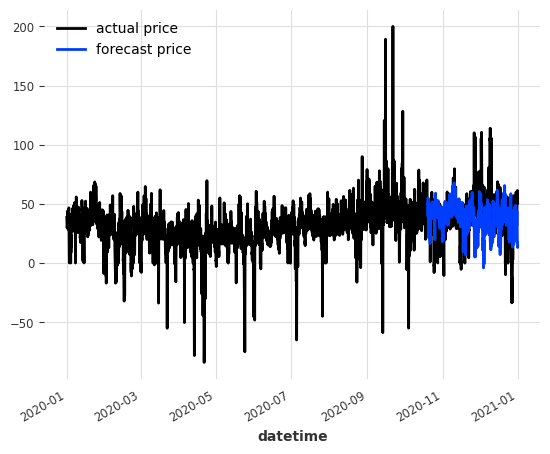

In [39]:
series_price.plot(label='actual price')
pred_price.plot(label='forecast price')

In [42]:
print(f'Mape = {mape(series_price, pred_price, inter_reduction=np.mean):.2f}%')

Mape = 1518.14%


In [11]:
backtest = model.historical_forecasts(
    series_price,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    overlap_end=False,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

In [12]:
print(f'MAPE = {mape(backtest, val_price):.2f}%')

MAPE = 104.46%


In [13]:
series_wind = TimeSeries.from_dataframe(
    df, 
    time_col="datetime",
    value_cols=["wind_speed"]
)
series_not_renewable = TimeSeries.from_dataframe(
    df,
    time_col='datetime',
    value_cols=['not_renewable']
)

In [14]:
scaler = Scaler()

In [15]:
train_price_scaled, not_renewable_scaled, wind_scaled = scaler.fit_transform([
    train_price, 
    series_not_renewable, 
    series_wind
])

In [16]:
pd.notnull(not_renewable_scaled)

True

In [17]:
pd.notnull(wind_scaled)

True

In [18]:
time_covariates = concatenate(
    [
        dt_attr(series_price.time_index, 'month', dtype=np.float32),
        dt_attr(series_price.time_index, 'hour', dtype=np.float32),
        dt_attr(series_price.time_index, 'weekday', dtype=np.float32)
    ],
    axis='component'
)

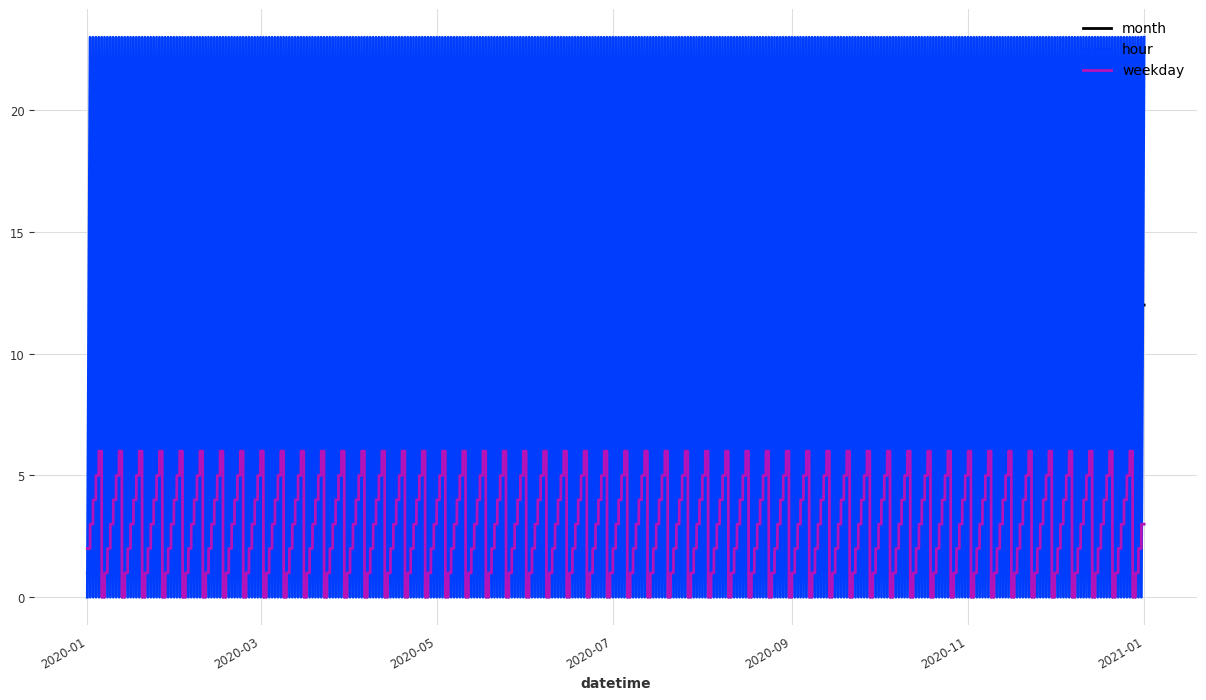

In [19]:
plt.figure(figsize=(15, 8))
time_covariates.plot()

In [20]:
pd.notnull(time_covariates)

True

In [21]:
time_covariates

<TimeSeries (DataArray) (datetime: 8784, component: 3, sample: 1)>
array([[[ 1.],
        [ 0.],
        [ 2.]],

       [[ 1.],
        [ 1.],
        [ 2.]],

       [[ 1.],
        [ 2.],
        [ 2.]],

       ...,

       [[12.],
        [21.],
        [ 3.]],

       [[12.],
        [22.],
        [ 3.]],

       [[12.],
        [23.],
        [ 3.]]], dtype=float32)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
  * component  (component) object 'month' 'hour' 'weekday'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [43]:
model_covariants = RegressionModel(
    lags=[-7000,-168],
    lags_future_covariates=[-168, 0],
)

In [44]:
model_covariants.fit(
    train_price_scaled,
    future_covariates=[not_renewable_scaled, wind_scaled, time_covariates]
)

In [45]:
pred_price = model_covariants.predict(
    series=train_price_scaled,
    future_covariates=[not_renewable_scaled, wind_scaled, time_covariates],
    n=len(val_price)
)

pred_price = scaler.inverse_transform(pred_price)

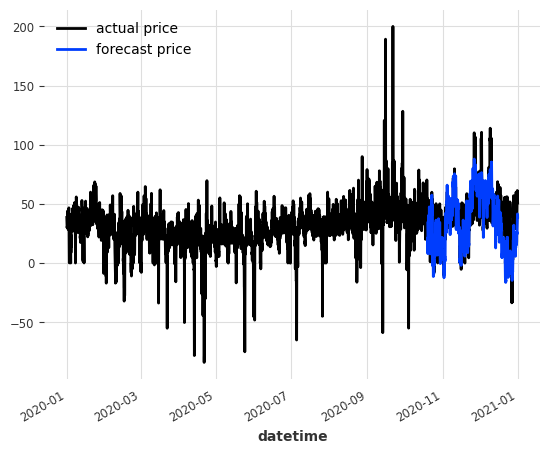

In [46]:
series_price.plot(label='actual price')
pred_price.plot(label='forecast price')

In [26]:
mape(series_price, pred_price, inter_reduction=np.mean)

247.86673025559512

In [33]:
backtest_covariants = model_covariants.historical_forecasts(
    series_price,
    start=0.98,
    future_covariates=time_covariates,
    forecast_horizon=168,
    verbose=True
)

  0%|          | 0/10 [00:00<?, ?it/s]


Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


LinAlgError: SVD did not converge in Linear Least Squares